In [1]:
# Loading packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Importing data

In [2]:
movie = pd.read_csv("movie_metadata.csv")
# movie.head(3)

imdb = pd.read_csv("imdb.csv",escapechar='\\')
# imdb.head(3)

In [3]:
movie['tid'] = movie['movie_imdb_link'].str[26:35]

In [4]:
# Drop duplicates
imdb.drop_duplicates(subset = 'tid', inplace=True)
movie.drop_duplicates(subset = 'tid', inplace=True)

In [5]:
# Have done inner merge because doing "outer" merge will lead to many missing values each column
# (approx 70% missing values in many columns)

In [6]:
data = pd.merge(imdb, movie, how='inner', on='tid')
# data.head(2)

# Pre-processing

In [7]:
# Repeated columns
data = data.drop(['fn','url','movie_title','movie_imdb_link','title_year','imdb_score','num_user_for_reviews'], axis = 1) 
# data.head(3)

df = data.drop(['wordsInTitle','nrOfGenre',
       'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'FilmNoir',
       'GameShow', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'RealityTV', 'Romance', 'SciFi', 'Short', 'Sport', 'TalkShow',
       'Thriller', 'War', 'Western',
       'plot_keywords'], axis = 1) 

In [8]:
# Creating new features

df['title'] = df['title'].str.replace(r"\(.*\)","")
df['title_length'] = df['title'].str.len()
df['title_length'].replace(0, np.nan, inplace=True)

df['duration_original_min'] = df['duration_x']/60

df.rename(columns = {'duration_y':'duration_DVD_min'}, inplace = True) 

In [9]:
df = df.drop(['duration_x'], axis = 1)

In [10]:
# Remove white spaces
df.replace('^\s+', '', regex=True, inplace=True) #front
df.replace('\s+$', '', regex=True, inplace=True) #end

# Missing data

In [11]:
# Percentage of nan
(df.isnull().sum() * 100 / len(df)).sort_values(ascending=False)

gross                        9.837728
budget                       6.152806
director_name                1.757945
director_facebook_likes      1.757945
content_rating               1.419878
aspect_ratio                 0.676133
duration_original_min        0.507099
imdbRating                   0.507099
ratingCount                  0.507099
actor_3_name                 0.270453
actor_3_facebook_likes       0.270453
year                         0.101420
color                        0.101420
actor_2_name                 0.101420
actor_2_facebook_likes       0.101420
language                     0.101420
facenumber_in_poster         0.067613
title_length                 0.033807
genres                       0.000000
nrOfPhotos                   0.000000
title                        0.000000
movie_facebook_likes         0.000000
country                      0.000000
type                         0.000000
nrOfWins                     0.000000
nrOfNominations              0.000000
nrOfUserRevi

# Correlation matrix

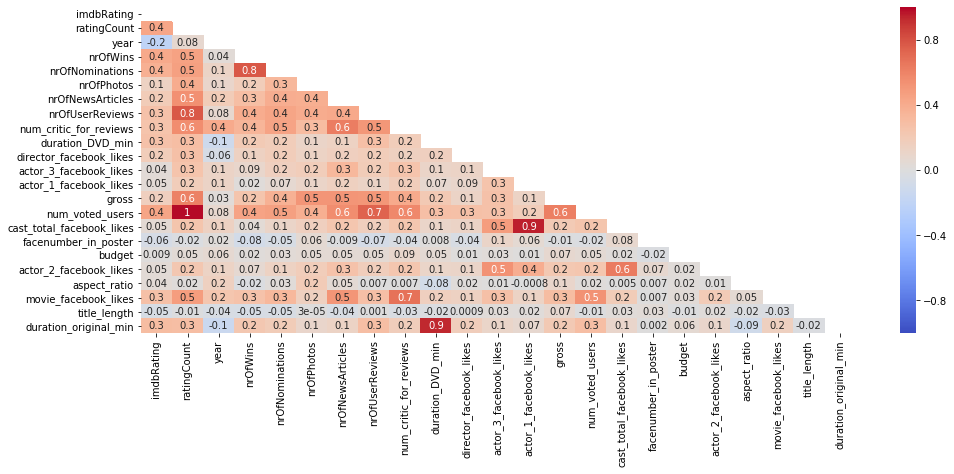

In [34]:
plt.figure(figsize=(16, 6))

matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',mask=matrix);

Variables that have values(n)
 -  n > 0.8 are highly positive correlated 
 -  0.8 > n > 0.5 are slight positive correlation
 -  nearly 0 have no correlation

Same rules applies for the  negative correation as well

# Tables - groupby

In [13]:
df['color'].value_counts()

Color              2804
Black and White     151
Name: color, dtype: int64

This data is biased towards "colors" type (i.e) colors are approx. 18% more than Black and White in the given data.

Since the data is very biased towards "color", these observations may not be True when more BW data are collected.

In [14]:
df.groupby(["color","type"])["tid"].count()

color            type       
Black and White  video.movie     148
                 video.tv          3
Color            video.movie    2756
                 video.tv         48
Name: tid, dtype: int64

This data is biased towards "colors - movie" type than TV type.

In [15]:
g1 = df.groupby(["color","type"])["nrOfWins","nrOfNominations"].sum()
g1.reset_index()
g1["Wins %"] = ((g1["nrOfWins"] / g1["nrOfNominations"])*100).round(1)
g1["Nomination %"] = 100
g1

nrOfWins  nrOfNominations  Wins %  Nomination %
color           type                                                        
Black and White video.movie      1692             1847    91.6           100
                video.tv           14               35    40.0           100
Color           video.movie     18595            26295    70.7           100
                video.tv          476             1345    35.4           100

Though the nrOfNominations & nrOfWins has increased to a large percent when compared to BW, 
the wins as a % of Nominations has decreased to the large amount.

In [16]:
# Directors based on Max wins

df_agg = df.groupby(['color','type','director_name']).agg({'nrOfWins': 'sum'})
g2 = df_agg['nrOfWins'].groupby(level=0, group_keys=False)
g2.nlargest(3)

color            type         director_name      
Black and White  video.movie  Michel Hazanavicius    137
                              Martin Scorsese         81
                              Baz Luhrmann            75
Color            video.movie  Steven Spielberg       367
                              Peter Jackson          342
                              Ang Lee                295
Name: nrOfWins, dtype: int64

In [17]:
# Directors based on Max nominations

df_agg = df.groupby(['color','type', 'director_name']).agg({'nrOfNominations': 'sum'})
g3 = df_agg['nrOfNominations'].groupby(level=0, group_keys=False)
g3.nlargest(3)

color            type         director_name      
Black and White  video.movie  Michel Hazanavicius    111
                              Rob Marshall            96
                              Martin Scorsese         90
Color            video.movie  Steven Spielberg       598
                              Martin Scorsese        412
                              Peter Jackson          411
Name: nrOfNominations, dtype: int64

In [18]:
# Max wins based on directors and 1st actor combo

df_agg = df.groupby(['color','type', 'director_name','actor_1_name']).agg({'nrOfWins': 'sum'})
g4 = df_agg['nrOfWins'].groupby(level=0, group_keys=False)
g4.nlargest(3)

color            type         director_name        actor_1_name     
Black and White  video.movie  Michel Hazanavicius  Bérénice Bejo        137
                              Baz Luhrmann         Jim Broadbent         75
                              Steven Spielberg     Liam Neeson           70
Color            video.movie  Peter Jackson        Christopher Lee      158
                              Jason Reitman        J.K. Simmons         137
                              Steve McQueen        Quvenzhané Wallis    131
Name: nrOfWins, dtype: int64

In [19]:
# Max wins based on directors and 1st & 2nd actor combo

df_agg = df.groupby(['color','type', 'director_name','actor_1_name','actor_2_name']).agg({'nrOfWins': 'sum'})
g5 = df_agg['nrOfWins'].groupby(level=0, group_keys=False)
g5.nlargest(3)

color            type         director_name        actor_1_name       actor_2_name  
Black and White  video.movie  Michel Hazanavicius  Bérénice Bejo      Ed Lauter         137
                              Baz Luhrmann         Jim Broadbent      Kylie Minogue      75
                              Steven Spielberg     Liam Neeson        Embeth Davidtz     70
Color            video.movie  Peter Jackson        Christopher Lee    Orlando Bloom     158
                              Steve McQueen        Quvenzhané Wallis  Scoot McNairy     131
                              Peter Jackson        Orlando Bloom      Billy Boyd        122
Name: nrOfWins, dtype: int64

In [20]:
# Directors who earned max profit %

g6 = df.groupby(["color","type", 'director_name','tid','duration_original_min'])["budget","gross"].mean()
g6.reset_index()
g6["Profit %"] = (((g6["gross"] - g6["budget"])/g6["budget"])*100).round(0)
# g6
g6 = g6['Profit %'].groupby(level=0, group_keys=False)
g6.nlargest(3)

color            type         director_name      tid        duration_original_min
Black and White  video.movie  Daniel Myrick      tt0185937  81.0                     234117.0
                              Darren Aronofsky   tt0138704  84.0                       5262.0
                              Richard Linklater  tt0102943  97.0                       5237.0
Color            video.movie  Oren Peli          tt1179904  86.0                     719349.0
                              Tobe Hooper        tt0072271  83.0                      36843.0
                              Robert Rodriguez   tt0104815  81.0                      29056.0
Name: Profit %, dtype: float64

In [21]:
# It can be infered that Directors who earned max Profit have almost made short durations movies

In [22]:
# Directors who earned max loss %

g7 = df.groupby(["color","type", 'director_name','tid','duration_original_min'])["budget","gross"].mean()
g7.reset_index()
g7["Profit %"] = (((g7["gross"] - g7["budget"])/g7["budget"])*100).round(0)
# g7
g7 = g7['Profit %'].groupby(level=0, group_keys=False)
g7.nsmallest(3)

color            type         director_name    tid        duration_original_min
Black and White  video.movie  Fritz Lang       tt0017136  153.0                   -100.0
                              Martin Scorsese  tt0081398  129.0                   -100.0
                              Orson Welles     tt0040525  81.0                    -100.0
Color            video.movie  Akira Kurosawa   tt0107474  134.0                   -100.0
                              Akiva Goldsman   tt1837709  118.0                   -100.0
                              Anurag Basu      tt1198101  123.0                   -100.0
Name: Profit %, dtype: float64

In [23]:
# It is seen that most of the Long durations movies have faced max loss

In [24]:
# Languages in which each video type made

df_agg = df.groupby(["color","type","language"]).agg({'language': 'count'})
g5 = df_agg['language'].groupby(level=0, group_keys=False)
g5.nlargest(3)

color            type         language
Black and White  video.movie  English      130
                              German         5
                 video.tv     English        3
Color            video.movie  English     2603
                 video.tv     English       45
                 video.movie  French        33
Name: language, dtype: int64

In [25]:
# English lang. movies are mostly made during both BW & Color period  

# Charts

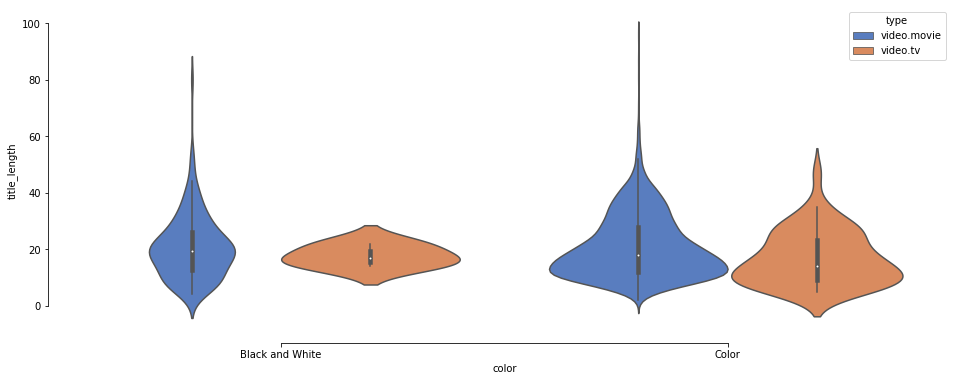

In [26]:
# Title length for each video type

plt.figure(figsize=(16, 6))

sns.violinplot(x="color", y="title_length", hue="type",
                    data=df, palette="muted")

sns.despine(offset=10, trim=True)

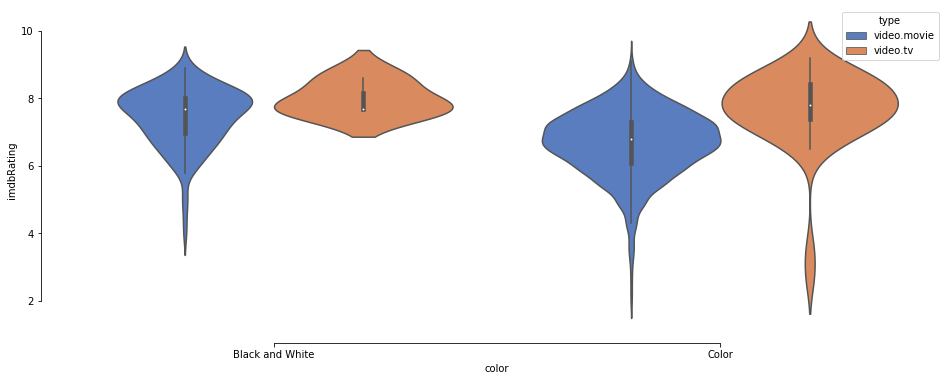

In [27]:
# imdb rating for each video type

plt.figure(figsize=(16, 6))

sns.violinplot(x="color", y="imdbRating", hue="type",
                    data=df, palette="muted")

sns.despine(offset=10, trim=True)

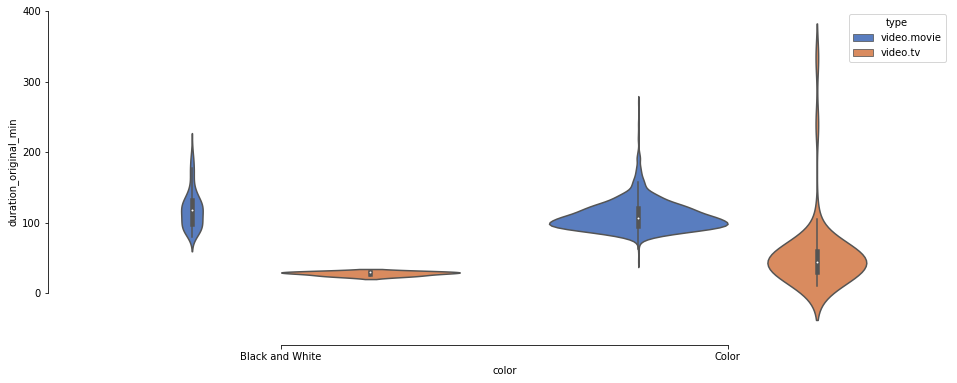

In [28]:
# Duration for each video type

plt.figure(figsize=(16, 6))

sns.violinplot(x="color", y="duration_original_min", hue="type",
                    data=df, palette="muted")

sns.despine(offset=10, trim=True)

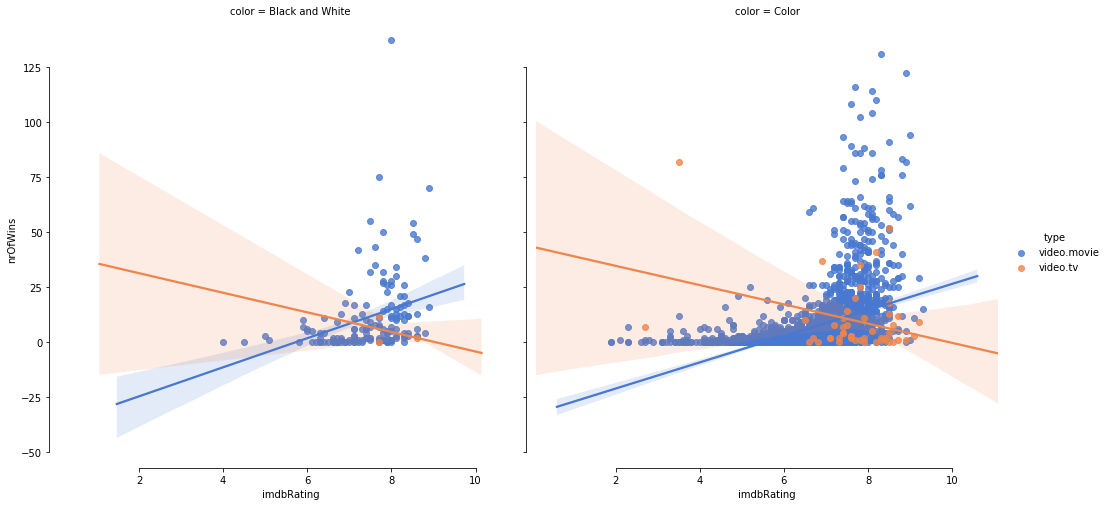

In [29]:
# Trend of Number of wons across ImdbRating

sns.lmplot(y="nrOfWins", x="imdbRating",hue="type",col='color', 
           palette="muted",height=7,
           data=df)

sns.despine(offset=10, trim=True)

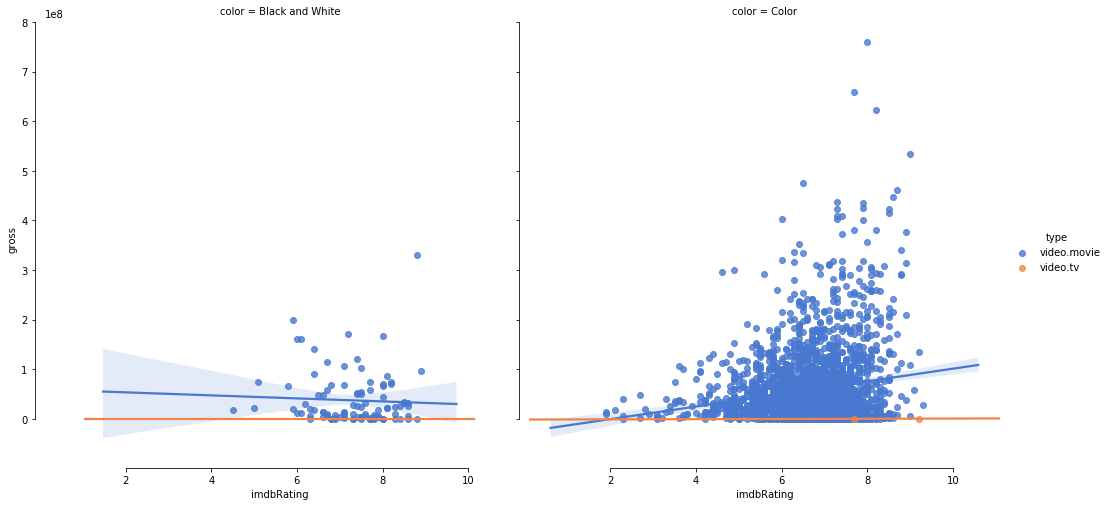

In [30]:
# Gross vs Imdb Rating

sns.lmplot(y="gross", x="imdbRating",hue="type",col='color', 
           palette="muted",height=7,
           data=df)

sns.despine(offset=10, trim=True)

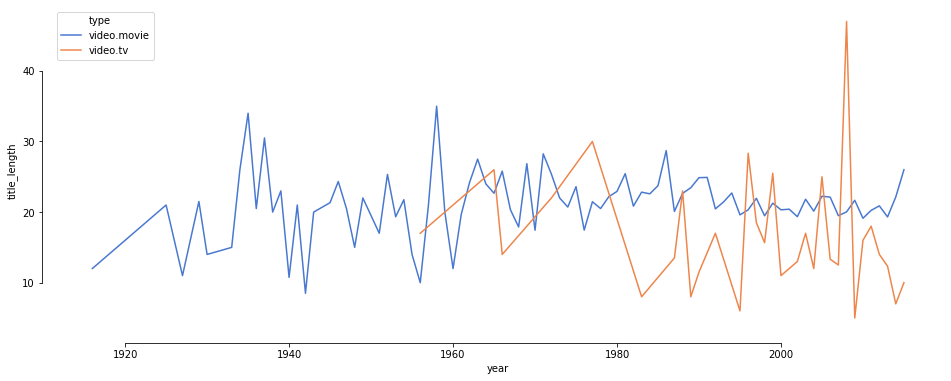

In [31]:
# Title length over time

plt.figure(figsize=(16, 6))

sns.lineplot(y="title_length", x="year", hue = "type",
           palette="muted",ci = None,
             
           data=df)

sns.despine(offset=10, trim=True)

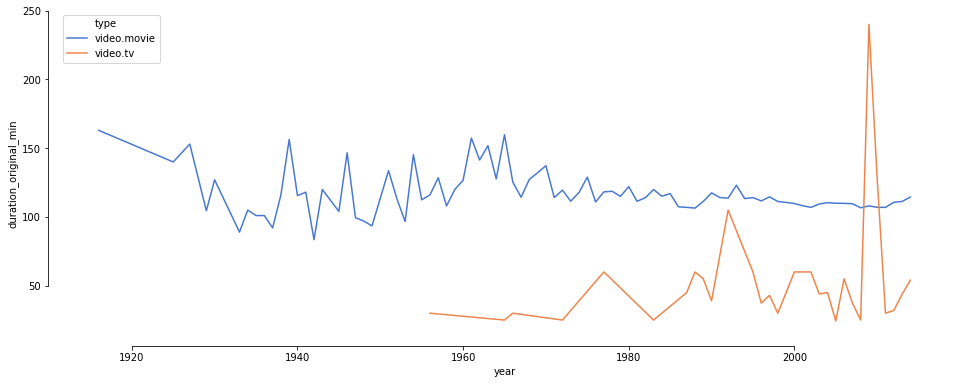

In [32]:
# Duration over time

plt.figure(figsize=(16, 6))

sns.lineplot(y="duration_original_min", x="year", hue = "type",
           palette="muted",ci = None,
             
           data=df)

sns.despine(offset=10, trim=True)

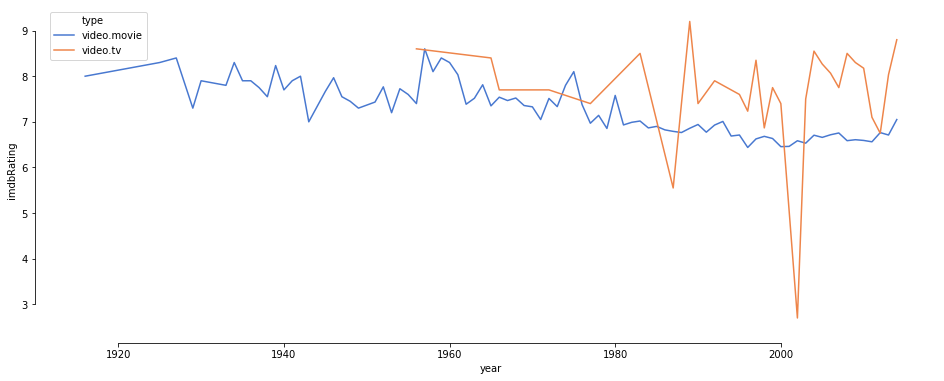

In [33]:
# Imdb Rating over time

plt.figure(figsize=(16, 6))

sns.lineplot(y="imdbRating", x="year", hue = "type",
           palette="muted",ci = None,
             
           data=df)

sns.despine(offset=10, trim=True)